<a href="https://colab.research.google.com/github/King-of-Haskul/Machine-Learning-And-Data-Science/blob/main/Boston_Housing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
train_targets[0] #These are median values of owner-occupied homes in thousands of dollars

15.2

### Normalizing the data

In [4]:
import numpy as np

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean)/std
#We normalize the test set using the mean and standard deviation calculated on the training set
test_data = (test_data - mean)/std

### Building the network

In [5]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer ='rmsprop', loss='mse', metrics=['mae'])
  return model

### K-fold Validation

Since we have very few data points, using just one validation set would not suffice since it would be very small and would have high variance with regard to the validation split. Thus in such situations it is best practice to use k-fold cross-validation.

It consists of splitting the available data into K partitions, instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.

*Here we implement K-fold validation while also saving the validations logs at each fold:*

In [6]:
k = 4     #Choosing number of folds
num_val_samples = len(train_data) // k      #number of samples in each validation set
num_epochs = 500
all_mae_histories =[]

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets), 
                      epochs = num_epochs, batch_size=1, verbose=0) #verbose = 0 trains without printing
  
  mae_history = history.history['val_mae'] #This returns a list of mae on validation set for each epoch
  all_mae_histories.append(mae_history) #Saving the validations logs for each fold

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] #Taking the mean of the 4 models for each epoch

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


### Plotting Validation Scores

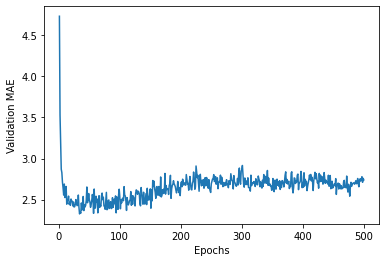

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, len(average_mae_history)+1)
plt.plot(epochs, average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()



*   Omiting the first 10 data points, which are on a different scale than the rest of the curve.
*   Replacing each point with an ***exponential moving average*** of the previous points, to obtain a smooth curve.



In [20]:
#Exponential moving average implementation
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points: #If smoothed_points is not empty
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else: #when smoothed_points is empty
      smoothed_points.append(point)

  return smoothed_points

In [21]:
smooth_mae_history = smooth_curve(average_mae_history[10:]) #obtaining smooth points while omitting the first 10 data points

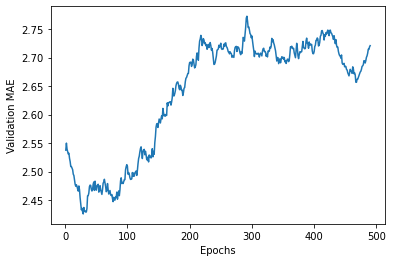

In [22]:
plt.clf()
plt.plot(range(1,len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Training the final model
With epochs = 80


In [27]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=0)
test_mae_score

2.7567901611328125

Our model is still off by about $2,757.